In [40]:
import time
import pandas as pd
import numpy as np
import plotly.express as px
import string
import nltk
from wordcloud import WordCloud, STOPWORDS 
import warnings 
import re
import os
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))
%matplotlib inline

#DEEP Learning
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In [41]:
start_time = time.time()
#(code below)

#Dataset downloaded from Kaggle
#Still relavant for comparison analysis to project data for airline delays

tweets = pd.read_csv('data_source_url.csv',sep=',')
display(tweets.shape)
#show the first 5 lines
display(tweets.head(5))
print("--- %.4f seconds ---"% (time.time() - start_time))

(14640, 15)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


--- 0.1182 seconds ---


In [42]:
#Subset tweet data and picks from the top 6 major airline based on frequency from EDA for Project
#Choose based on available data -  Southwest, American, United and Delta
tweets.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [43]:
# Example of tweets
tweets['text'].head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [0]:
#Clean up the dataset, select only positive and negative tweets:
tweets = tweets[tweets.airline_sentiment != "neutral"]

In [0]:
# Clean tweets beforehand to improve word cloud, remove user handles, stop words, word less than 4 characters, etc
# Code from:
# https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt

In [0]:
# remove twitter handles (@user)
tweets['tidy_tweet'] = np.vectorize(remove_pattern)(tweets['text'], "@[\w]*")
# remove special characters, numbers, punctuations
tweets['tidy_tweet'] = tweets['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")
# remove words less than 3 characters long
tweets['tidy_tweet'] = tweets['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>4]))

In [0]:
# Stopwords are English words that do not add much meaning to the sentence
comment_words = ' '
stopwords = set(STOPWORDS)

In [0]:
# Create 3 separate dataframes only containing either positive and negative tweets
# Positive
pos_df = tweets[tweets['airline_sentiment']=='positive']

# Negative
neg_df = tweets[tweets['airline_sentiment']=='negative']


In [49]:
# Example of positive tweets with high confidence
pos_high_conf = pos_df[pos_df['airline_sentiment_confidence']==1.0]
print(pos_high_conf['text'][9])
print(pos_high_conf['text'][11])
print(pos_high_conf['text'][12])

@VirginAmerica it was amazing, and arrived an hour early. You're too good to me.
@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D
@VirginAmerica This is such a great deal! Already thinking about my 2nd trip to @Australia &amp; I haven't even gone on my 1st trip yet! ;p


In [50]:
# Example of negative tweet with high confidence
neg_high_conf = neg_df[neg_df['airline_sentiment_confidence']==1.0]
print(neg_high_conf['text'][3])
print(neg_high_conf['text'][4])
print(neg_high_conf['text'][5])

@VirginAmerica it's really aggressive to blast obnoxious "entertainment" in your guests' faces &amp; they have little recourse
@VirginAmerica and it's a really big bad thing about it
@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA


In [51]:
pos_df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone', 'tidy_tweet'],
      dtype='object')

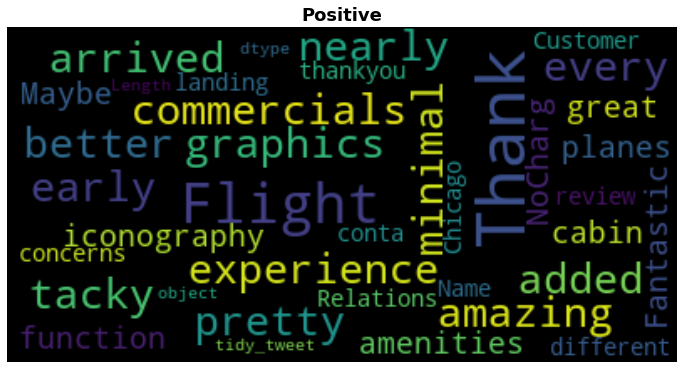

In [52]:
#WORD CLOUDS
# Positive wordcloud
wordcloud = WordCloud(
                    background_color='black',
                    stopwords=stopwords,
                    max_words=100,
                    max_font_size=40,
                    random_state=22).generate(str(pos_df['tidy_tweet']))
 
print(wordcloud)
fig = plt.figure(1, figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Positive",  fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.axis('off')
plt.show();

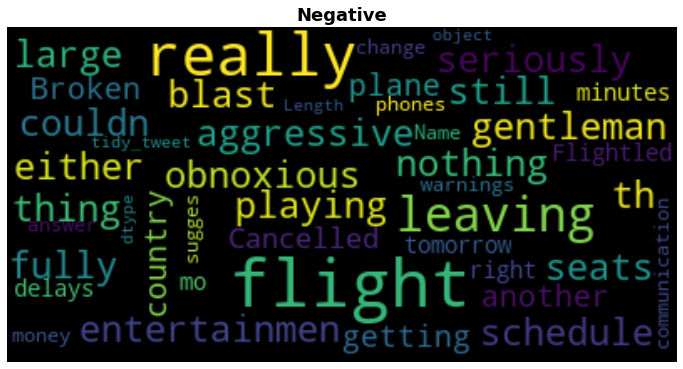

In [53]:
# Negative wordcloud
wordcloud = WordCloud(
                    background_color='black',
                    stopwords=stopwords,
                    max_words=100,
                    max_font_size=40,
                    random_state=12).generate(str(neg_df['tidy_tweet']))
 
print(wordcloud)
fig = plt.figure(1, figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Negative",  fontdict={'fontsize': 18, 'fontweight': 'extra bold'})
plt.axis('off')
plt.show();

In [54]:
start_time = time.time()
#(code below)

#Filter for the category - select only positive and negative tweets:
is_positive = pos_df['airline_sentiment'].str.contains("positive")
is_negative = neg_df['airline_sentiment'].str.contains("negative")
#is_neutral = tweets_sub['airline_sentiment'].str.contains("neutral")


print("--- %.4f seconds ---"% (time.time() - start_time))

--- 0.0133 seconds ---


In [55]:
start_time = time.time()
#(code below)
###
positive_tweets = pos_df[is_positive]
display(positive_tweets.shape)

#
negative_tweets = neg_df[is_negative]
display(negative_tweets.shape)
###
#neutral_tweets = tweets_sub[is_neutral]
#display(neutral_tweets.shape)

# 
worst_airline = negative_tweets[['airline','negativereason']]
("Worst Airline Based on the dataset:")
(worst_airline)

# Create the rank for the worst airline
cnt_worst_airline = worst_airline.groupby('airline', as_index=False).count()
print('The Worst Airlines are:')
display(cnt_worst_airline.sort_values('negativereason', ascending=False))


# Create the rank for the best airline

best_airline = positive_tweets[['airline','airline_sentiment_confidence']]
cnt_best_airline = best_airline.groupby('airline', as_index=False).count()
print('The Best Airlines are:')
display(cnt_best_airline.sort_values('airline_sentiment_confidence', ascending=False))

print("--- %.4f seconds ---"% (time.time() - start_time))

(2363, 16)

(9178, 16)

The Worst Airlines are:


,airline,negativereason
4,United,2633
3,US Airways,2263
0,American,1960
2,Southwest,1186
1,Delta,955
5,Virgin America,181


The Best Airlines are:


,airline,airline_sentiment_confidence
2,Southwest,570
1,Delta,544
4,United,492
0,American,336
3,US Airways,269
5,Virgin America,152


--- 0.0555 seconds ---


In [56]:
from prettytable import PrettyTable #creating tables in jupyter notebook

x = PrettyTable()

x.field_names  = ["AIRLINES", "CONFIDENCE RANKINGS", "NEGATIVE REASONS"]

x.add_row(["Southwest", 570, 1186])
x.add_row(["Delta", 544, 955 ])
x.add_row(["United", 492, 2633])
x.add_row(["America", 336, 1960])

print(x)

+-----------+---------------------+------------------+
|  AIRLINES | CONFIDENCE RANKINGS | NEGATIVE REASONS |
+-----------+---------------------+------------------+
| Southwest |         570         |       1186       |
|   Delta   |         544         |       955        |
|   United  |         492         |       2633       |
|  America  |         336         |       1960       |
+-----------+---------------------+------------------+


In [57]:
cnt_worst_airline = worst_airline.groupby('airline', as_index=False).count()
print('The Worst Airlines are:')
display(cnt_worst_airline.sort_values('negativereason', ascending=False))

The Worst Airlines are:


,airline,negativereason
4,United,2633
3,US Airways,2263
0,American,1960
2,Southwest,1186
1,Delta,955
5,Virgin America,181


In [58]:
start_time = time.time()
#(code below)
## Create the rank for negative reason
motivation = negative_tweets[['airline','negativereason']]
#cnt_bad_flight_motivation = motivation.groupby('negativereason', as_index=False).count()
cnt_bad_flight_motivation = motivation.groupby(['negativereason'])['airline'].count().reset_index()

print('The Reasons for bad flight expriences are:')
display(cnt_bad_flight_motivation.sort_values('airline', ascending=False))

print("--- %.4f seconds ---"% (time.time() - start_time))

The Reasons for bad flight expriences are:


,negativereason,airline
3,Customer Service Issue,2910
7,Late Flight,1665
1,Can't Tell,1190
2,Cancelled Flight,847
8,Lost Luggage,724
0,Bad Flight,580
6,Flight Booking Problems,529
5,Flight Attendant Complaints,481
9,longlines,178
4,Damaged Luggage,74


--- 0.0233 seconds ---


In [59]:
x = PrettyTable()

x.field_names  = ["NEGATIVE REASONS", 'COUNT']

x.add_row(["Customer Service Issue", 2910])
x.add_row(["Late Flight", 1665])
x.add_row(["Can't Tell", 1190])
x.add_row(["Cancelled Flight", 847])
x.add_row(["Lost Luggage", 724])
x.add_row(["Bad Flight", 580])
x.add_row(["Flight Booking Problems", 529])
x.add_row(["Flight Attendant Complaints", 481])
x.add_row(["Long Lines", 178])
x.add_row(["Damaged Luggage", 74])
print(x)

+-----------------------------+-------+
|       NEGATIVE REASONS      | COUNT |
+-----------------------------+-------+
|    Customer Service Issue   |  2910 |
|         Late Flight         |  1665 |
|          Can't Tell         |  1190 |
|       Cancelled Flight      |  847  |
|         Lost Luggage        |  724  |
|          Bad Flight         |  580  |
|   Flight Booking Problems   |  529  |
| Flight Attendant Complaints |  481  |
|          Long Lines         |  178  |
|       Damaged Luggage       |   74  |
+-----------------------------+-------+


# DEEP LEARNING ON SENTIMENT

In [0]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
#https://github.com/frlim/data2040_final/blob/master/project_1/final_notebook.ipynb

In [63]:
tweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone', 'tidy_tweet'],
      dtype='object')

In [65]:
start_time = time.time()
#(code below)

# Investigate 2 columns that contains the tweet text and sentiment label
display(tweets[['text', 'airline_sentiment']].head())
display(tweets[['tidy_tweet', 'airline_sentiment']].head())


print("--- %.4f seconds ---"% (time.time() - start_time))

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


,tidy_tweet,airline_sentiment
1,added commercials experience tacky,positive
3,really aggressive blast obnoxious entertainmen...,negative
4,really thing about,negative
5,seriously would flight seats playing really th...,negative
6,nearly every,positive


--- 0.0363 seconds ---


In [62]:
#Count number of each type of tweet
tweets['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

In [0]:
#Tokenization:

max_fatures = 3500
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(tweets['tidy_tweet'].values)
X = tokenizer.texts_to_sequences(tweets['tidy_tweet'].values)
X = pad_sequences(X)


In [67]:
start_time = time.time()
#(code below)

#Neural Network

embed_dim = 130
lstm_out = 200

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

print("--- %.4f seconds ---"% (time.time() - start_time))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 15, 130)           455000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 130)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               264800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 402       
Total params: 720,202
Trainable params: 720,202
Non-trainable params: 0
_________________________________________________________________
None
--- 0.5895 seconds ---


In [68]:
start_time = time.time()
#(code below)

#Declare Dataset

Y = pd.get_dummies(tweets['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.30, random_state = 22)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)


print("--- %.4f seconds ---"% (time.time() - start_time))

(8078, 15) (8078, 2)
(3463, 15) (3463, 2)
--- 0.0125 seconds ---


In [69]:
start_time = time.time()
#(code below)


#Selecting some data for training and some for validation

X_val = X_train[:1000]
Y_val = Y_train[:1000]
######
partial_X_train = X_train[1000:]
partial_Y_train = Y_train[1000:]

print("--- %.4f seconds ---"% (time.time() - start_time))

--- 0.0003 seconds ---


In [70]:
start_time = time.time()
#(code below)

#Train Network
batch_size = 1012
history = model.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 15, 
                    batch_size=batch_size, 
                    validation_data=(X_val, Y_val))

print("--- %.4f seconds ---"% (time.time() - start_time))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 7078 samples, validate on 1000 samples
Epoch 1/15





7078/7078 [==============================] - 8s 1ms/step - loss: 0.6330 - acc: 0.7437 - val_loss: 0.5446 - val_acc: 0.7900
Epoch 2/15
7078/7078 [==============================] - 6s 780us/step - loss: 0.5319 - acc: 0.7933 - val_loss: 0.5191 - val_acc: 0.7900
Epoch 3/15
7078/7078 [==============================] - 6s 784us/step - loss: 0.4909 - acc: 0.7933 - val_loss: 0.4671 - val_acc: 0.7900
Epoch 4/15
7078/7078 [==============================] - 6s 794us/step - loss: 0.4253 - acc: 0.7984 - val_loss: 0.4090 - val_acc: 0.8430
Epoch 5/15
7078/7078 [==============================] - 6s 795us/step - loss: 0.3602 - acc: 0.8372 - val_loss: 0.3533 - val_acc: 0.8560
Epoch 6/15
7078/7078 [==============================] - 6s 783us/step - loss: 0.3070 - acc: 0.8744 - val_loss: 0.3268 - val_acc: 0.8630
Epoch 7/15
7078/7078 [==============

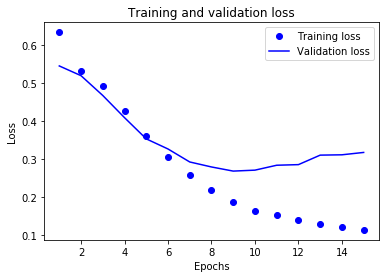

<Figure size 864x648 with 0 Axes>

--- 0.2521 seconds ---


In [71]:
start_time = time.time()
#(code below)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure(figsize=(12,9))
plt.show()

print("--- %.4f seconds ---"% (time.time() - start_time))

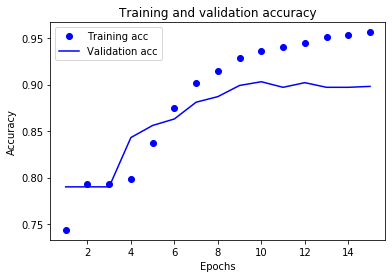

<Figure size 864x648 with 0 Axes>

--- 0.2361 seconds ---


In [72]:
start_time = time.time()
#(code below)

plt.clf()
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure(figsize=(12,9))
plt.show()

print("--- %.4f seconds ---"% (time.time() - start_time))

In [73]:
start_time = time.time()
#(code below)

pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_test)):
    
    result = model.predict(X_test[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_test[x]):
        if np.argmax(Y_test[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_test[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1


print("Positive Accuracy", round((pos_correct/pos_cnt*100),2), "%")
print("Negative Accuracy", round((neg_correct/neg_cnt*100),2), "%")


print("--- %.4f seconds ---"% (time.time() - start_time))

Positive Accuracy 65.65 %
Negative Accuracy 95.82 %
--- 10.0057 seconds ---



## References

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
https://realpython.com/python-keras-text-classification/
https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
